In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math 
from scipy.optimize import minimize
import patsy
from scipy.special import gammaln

In [2]:
data = pd.read_csv("/home/jovyan/Desktop/MGTA495-2/projects/Project 2/blueprinty.csv")

In [3]:
print(data.head())

   Unnamed: 0  patents     region   age  iscustomer
0           1        0    Midwest  32.5           0
1         786        3  Southwest  37.5           0
2         348        4  Northwest  27.0           1
3         927        3  Northeast  24.5           0
4         830        3  Southwest  37.0           0


In [4]:
customer_yes = data[data['iscustomer']== 1]
customer_no = data[data['iscustomer']== 0]

In [5]:
mean_customer_yes = customer_yes['patents'].mean()
mean_customer_no = customer_no['patents'].mean()

print(mean_customer_yes)
print(mean_customer_no)

4.091370558375634
3.6231772831926325


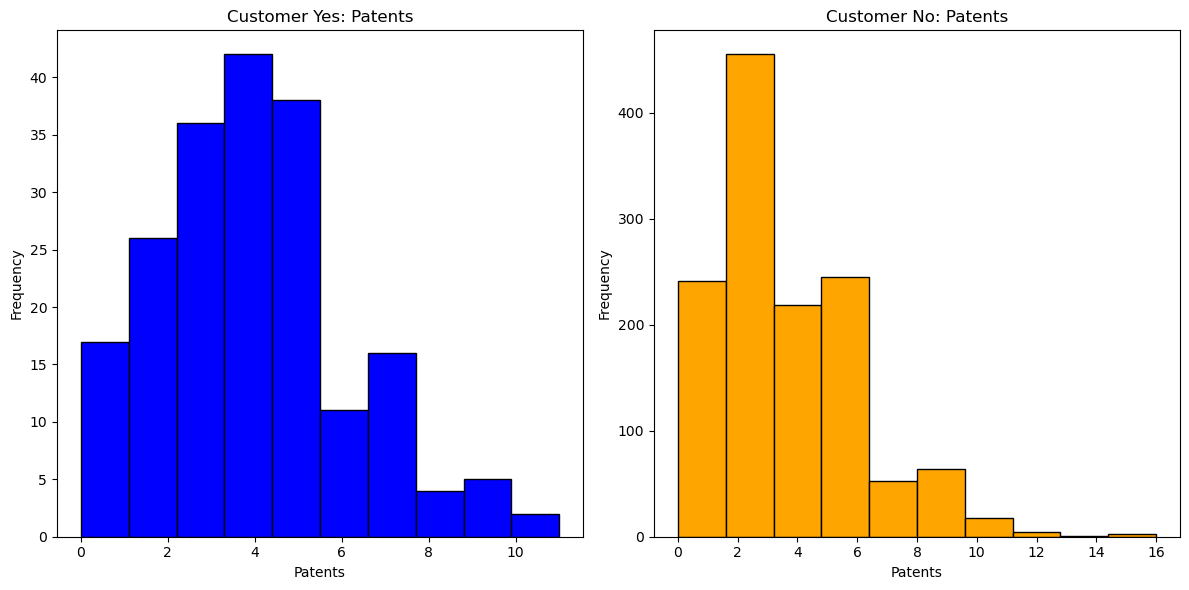

In [6]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histograms for customer_yes and customer_no datasets
axs[0].hist(customer_yes['patents'], bins=10, color='blue', edgecolor='black')
axs[0].set_title('Customer Yes: Patents')
axs[0].set_xlabel('Patents')
axs[0].set_ylabel('Frequency')

axs[1].hist(customer_no['patents'], bins=10, color='orange', edgecolor='black')
axs[1].set_title('Customer No: Patents')
axs[1].set_xlabel('Patents')
axs[1].set_ylabel('Frequency')

# Adjust layout and show plots
plt.tight_layout()
plt.show()



Customer_no is right skewed compared to customer_yes, and from this we can confer that while the means show that customer_yes has a small number more patents than customer_no but customer_no has significantly more variance

Blueprinty customers are not selected at random. It may be important to account for systematic differences in the age and regional location of customers vs non-customers.

## Customer Distribution by Region 

In [7]:


# Grouping and summarizing for customer_yes DataFrame
grouped_yes = customer_yes.groupby('region').agg(
    count=('region', 'size'),
).reset_index()
grouped_yes['pct'] = grouped_yes['count'] / len(customer_yes)

# Grouping and summarizing for customer_no DataFrame
grouped_no = customer_no.groupby('region').agg(
    count=('region', 'size'),
).reset_index()
grouped_no['pct'] = grouped_no['count'] / len(customer_no)

# Viewing the summarized results
print(grouped_yes)
print(grouped_no)


      region  count       pct
0    Midwest     17  0.086294
1  Northeast    113  0.573604
2  Northwest     16  0.081218
3      South     20  0.101523
4  Southwest     31  0.157360
      region  count       pct
0    Midwest    207  0.158864
1  Northeast    488  0.374520
2  Northwest    171  0.131236
3      South    171  0.131236
4  Southwest    266  0.204144


The table above shows fewer customers in all regions in the customer_no category
The table splits customer data into two categories based on their status (Yes or No)
For customers with a "Yes" status:
Northeast has the highest percentage of customers at 57.36%.
The other regions follow much lower, with Southwest at 15.74%, South at 10.15%, Midwest at 8.63%, and Northwest at 8.12%.
For customers with a "No" status:
Northeast again leads with 37.45% of customers.
This is followed by Southwest at 20.41%, and Midwest, Northwest, and South all close to each other at 15.89%, 13.12%, and 13.12% respectively.

## Customer Distribution by Age

Mean Age of Customers Yes: 24.1497461928934
Mean Age of Customers No: 26.691481197237145


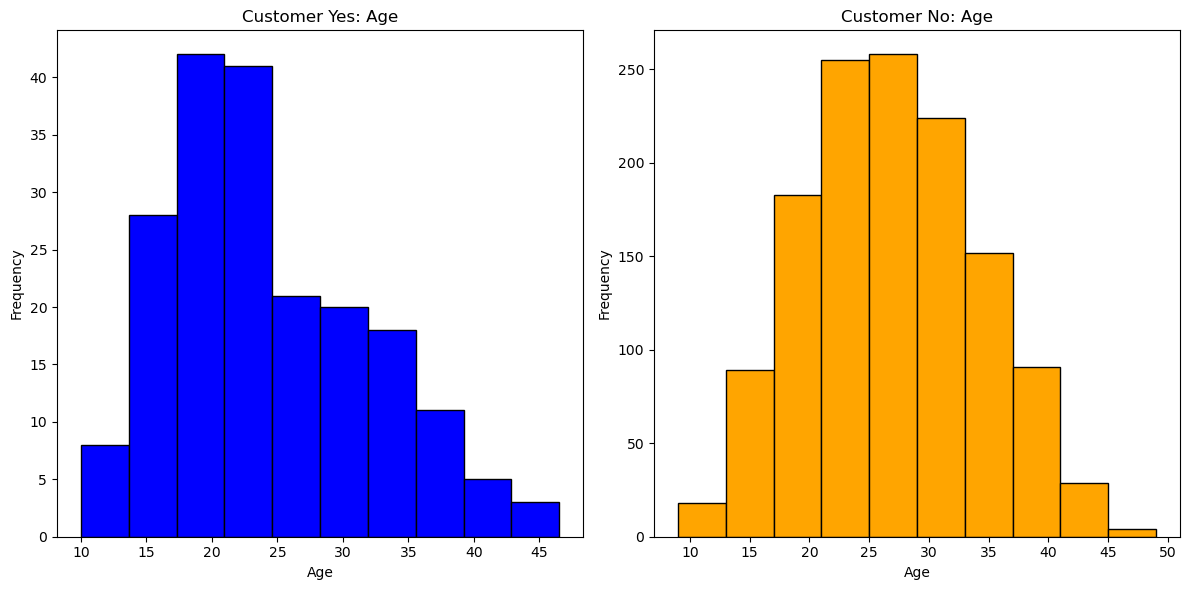

In [8]:
# Calculate the mean age for customer_yes and customer_no groups
mean_age_yes = customer_yes['age'].mean()
mean_age_no = customer_no['age'].mean()

print("Mean Age of Customers Yes:", mean_age_yes)
print("Mean Age of Customers No:", mean_age_no)

# Create a 1-row x 2-column grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram of age for customer_yes
axs[0].hist(customer_yes['age'], bins=10, color='blue', edgecolor='black')
axs[0].set_title('Customer Yes: Age')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

# Plot histogram of age for customer_no
axs[1].hist(customer_no['age'], bins=10, color='orange', edgecolor='black')
axs[1].set_title('Customer No: Age')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Observations
1- Region Impact: The Northeast dominates in customer numbers for both statuses, suggesting it may be a key market or has a larger base of the targeted demographic. 

2- Age Differences: Customers with a 'Yes' status are generally younger compared to those with a 'No' status, indicating that the younger customers are more active and engaged. 

3- Geographic Disparities: There is a clear geographic disparity in customer distribution. The Northeast has a much higher concentration of customers, possibly indicating regional preferences or more succesful market penetration. 

The likelihood (or log-likelihood) function (function of lambda and Y) for the Poisson model. 

In [9]:


def poisson_loglikelihood(lmbda, Y):
    # Convert Y to a NumPy array for easier numerical computations
    Y = np.array(Y)

    # Calculate the Poisson likelihood using NumPy's vectorized operations
    likelihood = np.exp(-lmbda) * np.power(lmbda, Y) / np.array([math.factorial(y) for y in Y])

    # Compute the sum of log-likelihoods
    ll = np.sum(np.log(likelihood))
    return ll


todo: Use your function to plot lambda on the horizontal axis and the likelihood (or log-likelihood) on the vertical axis for a range of lambdas (use the observed number of patents as the input for Y).

/tmp/ipykernel_162602/1251463276.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  likelihood = np.exp(-lmbda) * np.power(lmbda, Y) / np.array([np.math.factorial(y) for y in Y])
/tmp/ipykernel_162602/1251463276.py:4: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(np.log(likelihood))


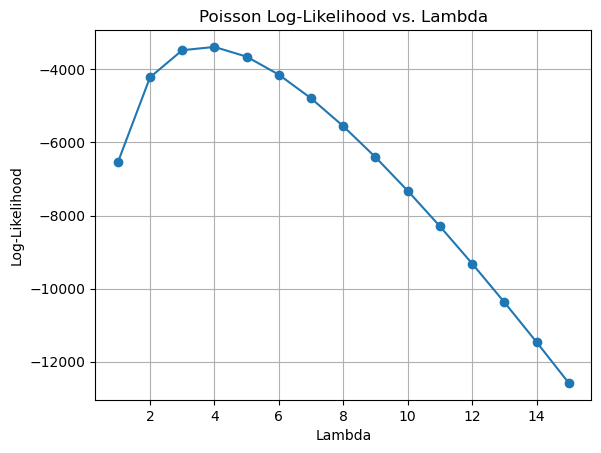

In [10]:
def poisson_loglikelihood(lmbda, Y):
    Y = np.array(Y)
    likelihood = np.exp(-lmbda) * np.power(lmbda, Y) / np.array([np.math.factorial(y) for y in Y])
    ll = np.sum(np.log(likelihood))
    return ll

# Generate a sequence of lambda values from min to max of data['patents']
min_patents = data['patents'].min()
max_patents = data['patents'].max()
lambdas = np.arange(min_patents, max_patents + 1)

# Initialize an empty list to store log-likelihoods
lls = []

# Calculate the log-likelihood for each lambda value
for lmbda in lambdas:
    lls.append(poisson_loglikelihood(lmbda, data['patents']))

# Plot lambda values against the corresponding log-likelihoods
plt.plot(lambdas, lls, marker='o', linestyle='-')
plt.xlabel('Lambda')
plt.ylabel('Log-Likelihood')
plt.title('Poisson Log-Likelihood vs. Lambda')
plt.grid(True)
plt.show()


1- Peak Log-Likelihood- The log-likelihood reaches its peak around 𝜆 = 4 which suggests that this value is the best fit to the observed patent data per the Poisson model 

2- Decrease in Log-Likelihood- As 𝜆 increases beyond 4, there is a sharp decline in the log-likelihood indicating  that the higher values deviate from the best fit. 

3- Shape of the curve- The curve is unimodal with a single peak which is typical in likelihood analysis. This suggests a clear optimum value for 𝜆. 

### Optimizing the likelihood function to find the MLE 

In [11]:

# Define the Poisson log-likelihood function (to maximize)
def poisson_loglikelihood(lmbda, Y):
    Y = np.array(Y)
    likelihood = np.exp(-lmbda) * np.power(lmbda, Y) / np.array([np.math.factorial(y) for y in Y])
    ll = np.sum(np.log(likelihood))
    return -ll  # Negate because we will minimize

# Sample dataset (replace this with your actual dataset)
Y = data['patents']

# Initial guess for lambda
initial_guess = 2

# Optimize using `minimize`, with negation to perform maximization
result = minimize(poisson_loglikelihood, initial_guess, args=(Y,), method='L-BFGS-B')

# The optimized lambda value (maximum likelihood estimate)
mle_lambda = result.x[0]

# Display the MLE for lambda
print(f"MLE for lambda: {mle_lambda}")


MLE for lambda: 3.684666797460521


/tmp/ipykernel_162602/3143906707.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  likelihood = np.exp(-lmbda) * np.power(lmbda, Y) / np.array([np.math.factorial(y) for y in Y])


Next, we extend our simple Poisson model to a Poisson Regression Model such that $Y_i = \text{Poisson}(\lambda_i)$ where $\lambda_i = \exp(X_i'\beta)$. The interpretation is that the success rate of patent awards is not constant across all firms ($\lambda$) but rather is a function of firm characteristics $X_i$. Specifically, we will use the covariates age, age squared, region, and whether the firm is a customer of Blueprinty.

todo: Update your likelihood or log-likelihood function with an additional argument to take in a covariate matrix X. Also change the parameter of the model from lambda to the beta vector. In this model, lambda must be a positive number, so we choose the inverse link function g() to be exp() so that $\lambda_i = e^{X_i'\beta}$. For example:

In [12]:
def poisson_regression_likelihood(beta, Y, X):
    # Convert inputs to NumPy arrays for efficient computation
    beta = np.array(beta)
    Y = np.array(Y)
    X = np.array(X)
    
    # Compute lambda as the linear combination of X and beta using matrix multiplication
    lambda_ = np.dot(X, beta)
    
    # Ensure lambda is positive to avoid issues with log and exponentiation
    lambda_ = np.exp(lambda_)

    # Calculate the Poisson log-likelihood terms
    ll = -lambda_ + Y * np.log(lambda_) - np.array([math.log(math.factorial(y)) for y in Y])
    
    # Sum up the log-likelihood values
    return np.sum(ll)


todo: Use your function along with R's optim() or Python's sp.optimize() to find the MLE vector and the Hessian of the Poisson model with covariates. Specifically, the first column of X should be all 1's to enable a constant term in the model, and the subsequent columns should be age, age squared, binary variables for all but one of the regions, and the binary customer variable. Use the Hessian to find standard errors of the beta parameter estimates and present a table of coefficients and standard errors.



In [13]:

def gr(beta, Y, X):
    # Convert inputs to NumPy arrays for efficient computation
    beta = np.array(beta)
    Y = np.array(Y)
    X = np.array(X)
    
    # Compute lambda (using matrix multiplication with exponential)
    lambda_ = np.dot(X, beta)
    lambda_ = np.exp(lambda_)
    
    # Calculate the gradient of the Poisson log-likelihood
    gradient = (Y / lambda_) - 1
    
    return gradient


todo: Check your results using R's glm() function or Python sm.GLM() function.

In [14]:
data['region_enc'] = data['region'].astype('category').cat.codes
X = data[['age', 'iscustomer', 'region_enc']].copy()
X['age2'] = data['age'] ** 2

y, X_design = patsy.dmatrices('patents ~ age + I(age **2) + iscustomer + region_enc', data=data, return_type='dataframe')

# Now, X_design is equivalent to the R model matrix, with the response variable in `y`

In [15]:
# Scaling to 0->1
# for col in X.columns:
#     min = X[col].min()
#     max = X[col].max()
#     X[col] = (X[col]-min)/(max-min)

In [16]:
# Ensure X is a numpy array
X = np.array(X)  # Replace with actual data loading if necessary

# Add an intercept column to X (column of ones at the beginning)
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])

# Define the likelihood function
def poisson_regression_likelihood(params, X, Y):
    # Ensure params is used directly as a NumPy array

    eta = np.dot(X, params)
    mu = np.exp(eta)
    log_likelihood = np.sum(-mu + Y * np.log(mu) - gammaln(Y + 1))
    return -log_likelihood

# Initial parameters guess, ensure it's a numpy array
initial_params = np.ones(X_with_intercept.shape[1]) * 0.1

# Run the minimization
result = minimize(poisson_regression_likelihood, initial_params, args=(X_with_intercept, Y), method='BFGS')
mle_beta = result.x

print("MLE Beta Parameters:", mle_beta)

MLE Beta Parameters: [ 3888.60313757 62686.72655582   806.1        10072.09702937
 -1281.06857986]


/tmp/ipykernel_162602/2091401651.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(-mu + Y * np.log(mu) - gammaln(Y + 1))
/tmp/ipykernel_162602/2091401651.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(-mu + Y * np.log(mu) - gammaln(Y + 1))
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)
/tmp/ipykernel_162602/2091401651.py:12: RuntimeWarning: overflow encountered in exp
  mu = np.exp(eta)


In [17]:
#initial_params
print(X_with_intercept[:2,:])
np.dot(X_with_intercept [:2,:], initial_params)

[[1.00000e+00 3.25000e+01 0.00000e+00 0.00000e+00 1.05625e+03]
 [1.00000e+00 3.75000e+01 0.00000e+00 4.00000e+00 1.40625e+03]]


array([108.975, 144.875])

todo: Check your results using R's glm() function or Python sm.GLM() function.

In [18]:
import statsmodels.formula.api as smf
import statsmodels.api as sm 

# Fit a Poisson GLM model
glmmodel = smf.glm(
    formula='patents ~ age + np.power(age, 2) + C(region) + iscustomer',
    data=data,
    family=sm.families.Poisson()
).fit()

# Print the model summary
print(glmmodel.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                patents   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3275.9
Date:                Wed, 05 Jun 2024   Deviance:                       2178.8
Time:                        08:17:40   Pearson chi2:                 2.11e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1152
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

Intercept and Coefficients:
The Intercept is significant and negative, which suggests that the baseline log count of patents is negative, but typically this is more relevant when considered relative to the predictor variables. 
Region:

Coefficients for regions show mixed results:
Northeast has a positive and significant effect on patent counts (coef = 0.0986, p = 0.019), indicating higher patent activity compared to the baseline region (probably West or Midwest if not mentioned).
Other regions (Northwest, South, Southwest) do not show significant effects (p > 0.05), suggesting no statistically significant difference in patent counts compared to the baseline region.

Age and Age Squared:
Age has a positive significant coefficient (coef = 0.1445, p < 0.001), indicating that an increase in age is associated with a higher log-count of patents.
np.power(age, 2) or age squared has a negative significant coefficient (coef = -0.0029, p < 0.001), which suggests diminishing returns with increasing age, a typical outcome in models accounting for quadratic relationships.
IsCustomer:

The coefficient for iscustomer is 0.1181 with a p-value of 0.002, which is statistically significant. This indicates that being a customer of Blueprinty's software is associated with an increase in the expected log-count of patents, holding other factors constant.

# Conclusions:

**Effect of Age:** The positive coefficient for age and the negative coefficient for age squared together suggest that as age increases, the number of patents initially increases but at a diminishing rate.

**Effect of Region:** Only the Northeast region shows a statistically significant positive effect on patent counts compared to the reference region. The lack of significant findings for other regions may suggest regional variations in patent activities that are not universally higher or lower than the baseline.

**Effect of Blueprinty’s Software:**
The positive and significant coefficient for iscustomer suggests that using Blueprinty's software leads to an increase in patent filings. Specifically, being a customer is associated with an approximate 12.54% increase in patent counts (exp(0.1181) ≈ 1.1254), holding other factors constant.
This provides quantitative evidence supporting the effectiveness of Blueprinty's software in enhancing patent success among its users.

**Recommendations:**
Enhancing customer engagement and expanding in regions with significant positive effects.
Conducting further analysis to understand why some regions do not show a significant difference and possibly adjusting marketing or operational strategies accordingly.
Highlighting the positive impact of their software in promotional and customer communication strategies, particularly focusing on the age dynamics and regional benefits observed.

### Airbnb

In [19]:
airbnb = pd.read_csv('/home/jovyan/Desktop/MGTA495-2/projects/Project 2/airbnb.csv')
print(airbnb.describe())

         Unnamed: 0            id          days     bathrooms      bedrooms  \
count  40628.000000  4.062800e+04  40628.000000  40468.000000  40552.000000   
mean   20314.500000  9.698889e+06   1102.368219      1.124592      1.147046   
std    11728.437705  5.460166e+06   1383.269358      0.385884      0.691746   
min        1.000000  2.515000e+03      1.000000      0.000000      0.000000   
25%    10157.750000  4.889868e+06    542.000000      1.000000      1.000000   
50%    20314.500000  9.862878e+06    996.000000      1.000000      1.000000   
75%    30471.250000  1.466789e+07   1535.000000      1.000000      1.000000   
max    40628.000000  1.800967e+07  42828.000000      8.000000     10.000000   

              price  number_of_reviews  review_scores_cleanliness  \
count  40628.000000       40628.000000               30433.000000   
mean     144.760732          15.904426                   9.198370   
std      210.657597          29.246009                   1.119935   
min       10

In [20]:
airbnb2 = airbnb.dropna()

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

airbnb2['room_type'] = airbnb2['room_type'].astype('category')
airbnb2['instant_bookable'] = airbnb2['instant_bookable'].astype('category')

# Fit a Poisson GLM model
formula = 'number_of_reviews ~ days + room_type + bathrooms + bedrooms + price + \
           review_scores_cleanliness + review_scores_location + review_scores_value + \
           instant_bookable'
model1 = smf.glm(formula=formula, data=airbnb2, family=sm.families.Poisson()).fit()

# Print the model summary
print(model1.summary())


/tmp/ipykernel_162602/776694124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb2['room_type'] = airbnb2['room_type'].astype('category')
/tmp/ipykernel_162602/776694124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb2['instant_bookable'] = airbnb2['instant_bookable'].astype('category')


                 Generalized Linear Model Regression Results                  
Dep. Variable:      number_of_reviews   No. Observations:                30140
Model:                            GLM   Df Residuals:                    30129
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.9041e+05
Date:                Wed, 05 Jun 2024   Deviance:                   8.5945e+05
Time:                        08:17:42   Pearson chi2:                 1.18e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9655
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [22]:
correlation_matrix = airbnb2.iloc[:, 10:13].corr()

# Display the correlation matrix
print(correlation_matrix)


                           review_scores_cleanliness  review_scores_location  \
review_scores_cleanliness                   1.000000                0.327198   
review_scores_location                      0.327198                1.000000   
review_scores_value                         0.615623                0.448408   

                           review_scores_value  
review_scores_cleanliness             0.615623  
review_scores_location                0.448408  
review_scores_value                   1.000000  


In [23]:
airbnb2['room_type'] = airbnb2['room_type'].astype('category')
airbnb2['instant_bookable'] = airbnb2['instant_bookable'].astype('category')

# Define the formula for the GLM model
formula = 'number_of_reviews ~ days + room_type + bathrooms + bedrooms + price + review_scores_value + instant_bookable'

# Fit a GLM model with a Poisson family
model1 = smf.glm(formula=formula, data=airbnb2, family=sm.families.Poisson()).fit()

# Print the summary of the model
print(model1.summary())


/tmp/ipykernel_162602/2134171599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb2['room_type'] = airbnb2['room_type'].astype('category')
/tmp/ipykernel_162602/2134171599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb2['instant_bookable'] = airbnb2['instant_bookable'].astype('category')


                 Generalized Linear Model Regression Results                  
Dep. Variable:      number_of_reviews   No. Observations:                30140
Model:                            GLM   Df Residuals:                    30131
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.9420e+05
Date:                Wed, 05 Jun 2024   Deviance:                   8.6702e+05
Time:                        08:17:43   Pearson chi2:                 1.20e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9556
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### Model Interpretation 

**Intercept:**
**Coefficient: 2.7740 **- This value represents the log count of reviews for the baseline category (entire home/apt, not instantly bookable) when all other variables are at zero. This is essentially the starting point for the number of reviews.

**room_type:**
Private room (0.0187): The coefficient indicates that listings classified as private rooms have a slight positive effect on the number of reviews compared to entire homes/apartments, with other factors held constant.
Shared room (-0.1081): In contrast, shared rooms are associated with a significant decrease in the number of reviews compared to entire homes/apartments.

**instant_bookable[T.t] (0.4640):**
Listings that are instantly bookable tend to receive significantly more reviews than those that are not. This large positive coefficient suggests a strong preference or higher booking rate for instantly bookable properties.

**days (0.0005):**
This coefficient shows a very small positive impact on the number of reviews for each additional day a listing has been on Airbnb. The effect is small per day, but over many days, it could accumulate to a substantial increase.

**bathrooms (-0.1094):**
More bathrooms in a listing correlate with fewer reviews. This could be counterintuitive but might indicate that listings with more bathrooms are larger properties that are less frequently rented or are more expensive.

**bedrooms (0.0831):**
Each additional bedroom is associated with an increase in the number of reviews. This suggests that larger accommodations tend to be more popular or booked more frequently.

**price (-0.00007666):**
The negative coefficient indicates that higher prices are slightly associated with fewer reviews. This effect, while small, suggests price sensitivity among Airbnb users.

**review_scores_value (-0.0462):**
Higher scores for the value provided by the listing correlate with fewer reviews. This might indicate that extremely well-rated places in terms of value do not receive as many reviews, perhaps because expectations are precisely met or exceeded.